In [35]:
import pandas as pd
import matplotlib.pyplot as plt

## Hoe voorspel je de groei van FlickBike ?
#### In het bijzonder: hoe voorspel je het aantal verhuurde fietsen op de dagen tussen 10 december 2019 en 31 januari 2020?

De groei van FlickBike is van veel factoren afhankelijk, zowel externe als interne factoren. Veel factoren zullen en/of kunnen niet meegenomen worden in het model omdat deze onberekenbaar, onbereikbaar of niet noemenswaardig zijn. Alle andere factoren die wel beschikbaar zijn moeten op correlatie onderzocht worden. Als bepaalde eigenschappen veel correlatie tonen met de target eigenschap, kunnen deze belangrijk zijn voor het model.

Dit probleem kan lastig opgelost worden met classificatie. Er zal dan hoogstwaarschijnlijk overfitting plaatsvinden ivm het hoge aantal target features.
Een van de modellen die gebruikt kan worden voor dit probleem is een decision tree regressor. 

## Hoe kunnen bepaalde factoren invloed hebben of krijgen op het model  ?

#### Het weer

Voor het gebruiken van weer moeten eerst een aantal weer factoren gekozen worden. Intuitief zouden bijvoorbeeld de neerslag een invloed kunnen hebben op de verhuur van fietsen ivm het feit dat mensen niet van houden om nat te regenen. Maar dit blijft een aanname. Er zal eerst een correlatie moeten worden gezocht tussen weerfactoren en verandering in fiets verhuur / gebruik.

#### Dag van de week

De dag van de week kan ook zeer sterke correlatie hebben met het aantal gebruikte huurfietsen. Je zou zeggen dat doordeweeks meer fietsen gebruikt worden omdat veel mensen alleen doordeweeks werken. Door de dag van de week als integer (1-7) of als string (ma-su) kan een nieuwe kolom met data aan het verhuurbestand toegevoegd worden.

In [36]:
# read csv file
fb_df = pd.read_csv("C:\\github\\DIP\\bikes.csv", delimiter=',', index_col=0)

# convert series to date time values and cretae a new column with weekdays extracted from the datetime values
day_of_week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
fb_df['weekday'] = pd.to_datetime(fb_df['start_time']).dt.dayofweek.map(day_of_week)
fb_df.head()

,tripid,userid,bikeid,account,bikenumber,start_time,end_time,start_lat,start_lng,end_lat,end_lng,date,weekday
1,33838,13452,382,AR,6631000433,2019-01-01 06:46:03,2019-01-01 06:46:03,52.296065,4.787667,52.296200,4.787679,2019-01-01 06:46:00,Tuesday
2,33839,13452,812,AR,6631000146,2019-01-01 06:47:39,2019-01-01 06:47:39,52.295938,4.788336,52.295940,4.788557,2019-01-01 06:47:35,Tuesday
3,33851,13182,238,AR,6631000443,2019-01-01 14:15:36,2019-01-01 14:15:36,52.307337,4.807633,52.307336,4.807630,2019-01-01 14:15:32,Tuesday
4,33852,13182,238,AR,6631000443,2019-01-01 14:33:50,2019-01-01 14:33:50,52.308478,4.809970,52.308537,4.810099,2019-01-01 14:33:46,Tuesday
5,33867,12674,787,AG,6631000283,2019-01-01 20:11:05,2019-01-01 20:11:05,52.506522,4.727323,52.506809,4.732135,2019-01-01 20:11:01,Tuesday


Zoals te zien is in de onderstaande grafiek wordt er inderdaad meer gebruik gemaakt van de huurfietsen. 

<BarContainer object of 7 artists>

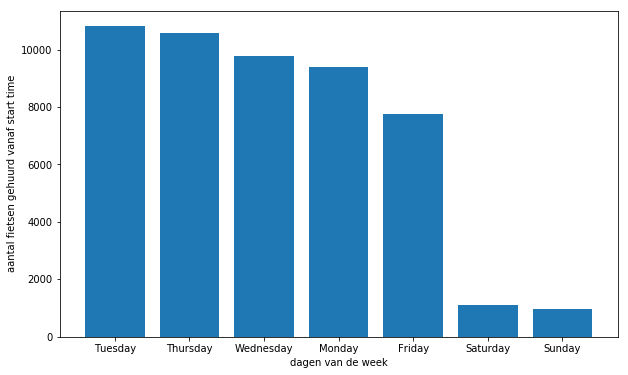

In [38]:
# count weekdays and plot a bar chart
value_counts = fb_df['weekday'].value_counts()
plt.figure(figsize=(10,6))
plt.ylabel('aantal fietsen gehuurd')
plt.xlabel('dagen van de week')
plt.bar(value_counts.keys(), value_counts.values)

#### Bijzondere dagen

Bijzondere dagen kunnen als boolean waarde opgeslagen worden in de dataset. Om de data expansie zo gering mogelijk te houden kunnen bepaalde groepen van bijzondere dagen als gecombineerde waarde bij de dataset gevoegd worden. Dit voorkomt het plaatsen van boolean waardes voor elke bijzondere dag. De groepering kan door bijvoorbeeld een cluster algoritme gemaakt worden waarbij de groepen worden gemaakt op basis van overkeenkomsten in relatie tot de target feature(s)

#### Eventuele andere factoren

Eventuele factoren om mee te nemen zijn:
- concurrenten die de markt opeisen
- financiele of medische crisissen
- bedrijfs/personeels veranderingen/problemen

## Hoe kan voorspeld worden op welke plekken fietstekorten kunnen ontstaan

Het is lastig om te voorspellen wanneer er tekorten ontstaan. Je weet immers nooit of iemand ergens een fiets misloopt. Een soort van feedback systeem zou misschien inzicht geven in waar mensen vaak geen fiets kunnen vinden. Ook kan je niet zien hoelang iemand naar een fiets heeft gezocht of hoelang deze persoon ervoor heeft moeten lopen.

Wel kan gekeken worden naar plekken waar veel fietsen worden gebruikt. Met andere woorden, in welk gebied wordt het meest een fiets gepakt en waar wordt het meest gefietst. Door de kijken naar de fiets routes kan een schatting gemaakt waar fietsen hotspots liggen.

## Hoe bereken je het minimaal aantal fietsen dat nodig is ?
